## In this file, we select the most representative user perception metrics to construct a new composite metric, 'quality_overall', which reflects the overall quality of each dialogue.

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [16]:
user_metrics = pd.read_csv("../../explore_user_common.csv")

In [17]:
### ! python -m pip install statsmodels

In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Select the all subjective rating columns
rating_cols = [
    'Therapeutic Alliance',
    'Perception of MI',
    'User Engagement - Focused Attention',
    'User Engagement - Perceived Usability',
    'User Engagement - Reward',
    'Perceived Empathy',
    'Readiness to Change (Delta)'
]

# Drop rows with missing values
df_valid = user_metrics[rating_cols].dropna()

# Normalize the values to a 0–1 scale
scaler = MinMaxScaler()
ratings_scaled = scaler.fit_transform(df_valid)
ratings_scaled.shape
ratings_scaled_df = pd.DataFrame(MinMaxScaler().fit_transform(df_valid), columns=df_valid.columns, index=df_valid.index)
vif_data=vif_data = pd.DataFrame()
vif_data["feature"] = ratings_scaled_df.columns

vif_data["VIF"] = [variance_inflation_factor(ratings_scaled_df.values, i)
                          for i in range(7)]
print(vif_data)

                                 feature        VIF
0                   Therapeutic Alliance  11.876646
1                       Perception of MI  10.184392
2    User Engagement - Focused Attention   7.589528
3  User Engagement - Perceived Usability  12.992394
4               User Engagement - Reward  19.616510
5                      Perceived Empathy   8.307074
6            Readiness to Change (Delta)   8.383962


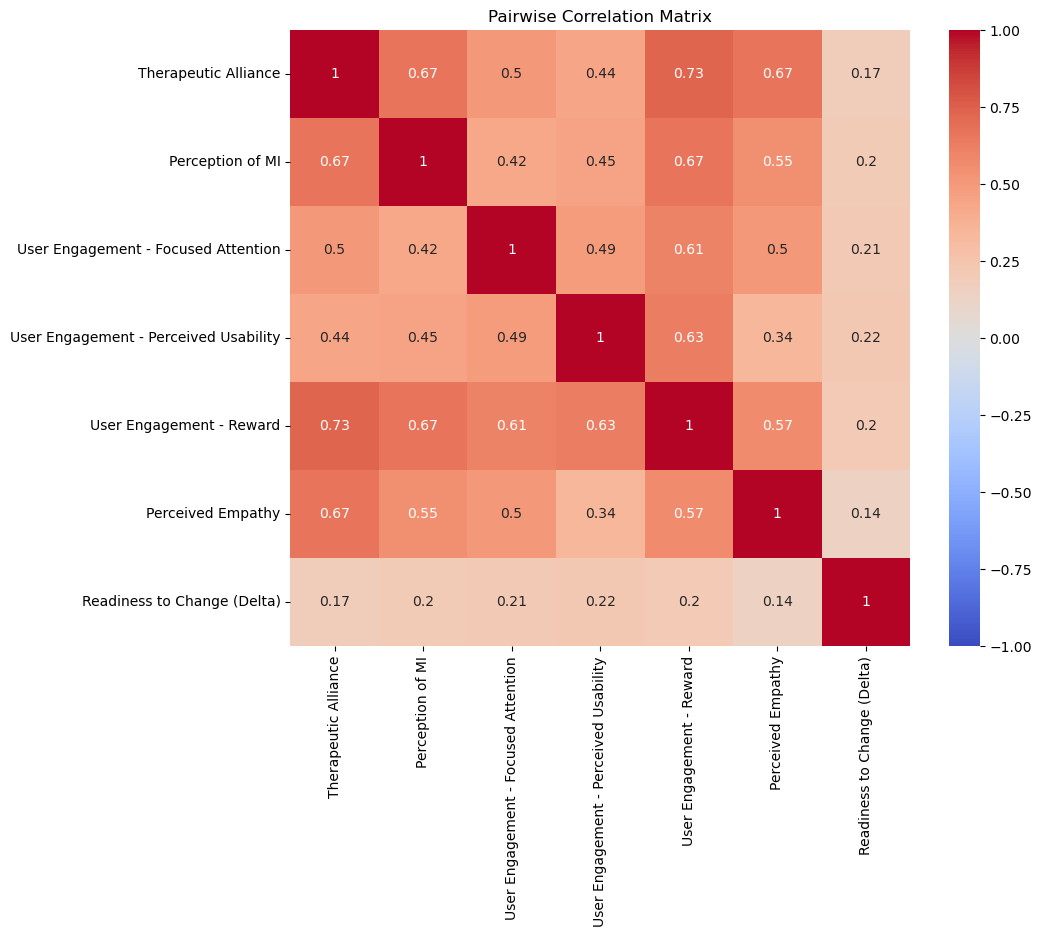

In [19]:
corr_matrix = df_valid.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Pairwise Correlation Matrix')
plt.show()

## PCA

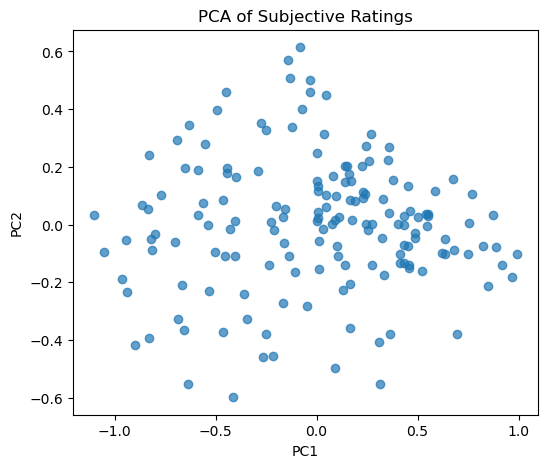

Top contributors to PC1 (likely the quality axis):
User Engagement - Reward                 0.484451
Perceived Empathy                        0.428516
Therapeutic Alliance                     0.409196
User Engagement - Perceived Usability    0.397356
User Engagement - Focused Attention      0.378626
Perception of MI                         0.330287
Readiness to Change (Delta)              0.062454
dtype: float64
Explained variance ratio: [0.60480965 0.13366239]
Cumulative variance explained: 0.7384720472367886


In [20]:
# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(ratings_scaled)

# Visualize the principal component space
plt.figure(figsize=(6, 5))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Subjective Ratings")
plt.show()

# Display variable contributions (loadings) to PC1
import pandas as pd
loadings = pd.Series(pca.components_[0], index=rating_cols)
print("Top contributors to PC1 (likely the quality axis):")
print(loadings.sort_values(ascending=False))

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative variance explained:", pca.explained_variance_ratio_.sum())


In [21]:
# Assume you choose these key metrics as the most influential indicators
selected = ['Perceived Empathy',  'User Engagement - Focused Attention', 'Readiness to Change (Delta)']

# Compute a composite quality score
user_metrics['quality_score'] = user_metrics[selected].mean(axis=1)

In [22]:
user_metrics.head()

,Unnamed: 0,Submission id,condition,Age,Sex,education,job,start_time,end_time,Time taken,...,User Engagement - Focused Attention,User Engagement - Perceived Usability,User Engagement - Reward,User Engagement - Overall,Communication Competence,Perceived Empathy,Readiness to Change (Delta),Stage of Change (Start),chat_id,quality_score
0,0,64d23c118b9d14b04645b779,framework,57,Male,Master-Abschluss,Musiker,2023-08-08 14:59:49.246355,2023-08-08 15:24:33.913124,24.74,...,4.333333,4.333333,4.666667,4.444444,5.00,4.333333,0.0,preparation,62,2.888889
1,1,64d252f78e65feea3deec857,framework,28,Female,Master-Abschluss,Computerlinguistik,2023-08-08 16:37:15.342634,2023-08-08 17:02:59.270676,25.73,...,2.333333,4.333333,4.333333,3.666667,5.00,4.333333,1.0,action,66,2.555556
2,2,64d0fe9256704afa0ffb99b9,framework,34,Male,Abitur,Berufstätig,2023-08-07 16:25:00.744608,2023-08-07 16:41:43.949226,16.72,...,2.666667,4.333333,4.000000,3.666667,4.50,2.666667,2.0,preparation,13,2.444444
3,3,64d36fedffb7901c74b18f75,no_system,30,Male,Bachelor-Abschluss,arbeitssuchend,2023-08-09 12:52:59.707858,2023-08-09 13:04:05.192081,11.09,...,3.000000,5.000000,4.666667,4.222222,4.50,4.000000,2.0,preparation,106,3.000000
4,4,64d370310153ff2a4844e7a8,framework,26,Male,Bachelor-Abschluss,Student Informatik M.Sc.,2023-08-09 12:54:12.839555,2023-08-09 13:13:46.172634,19.56,...,2.333333,4.666667,3.000000,3.333333,3.75,2.000000,-2.0,preparation,107,0.777778


In [23]:
from sklearn.linear_model import LinearRegression
X = user_metrics.loc[df_valid.index, ['quality_score']]
y = df_valid[rating_cols]

model = LinearRegression().fit(X, y)
r2 = model.score(X, y)
print("Variance explained by quality_score:", r2)

Variance explained by quality_score: 0.3503536329361747


In [24]:
# Save as CSV
user_metrics.to_csv("user_metrics_withCompositeQualityScore.csv", index=False)